In [1]:
2+4

6

In [5]:
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


8  CPU cores


In [6]:
import os
os.chdir("D:\CSE 4 PROJECT")

In [9]:
import pandas as pd
df1=pd.read_excel('df_train_train1.xlsx')
df2=pd.read_excel('df_train_valid.xlsx')

In [10]:
df1

,id_code,diagnosis,file_path,file_name
0,ef8c39eb9157,0,./train_image/ef8c39eb9157.png,ef8c39eb9157.png
1,ea4dcb055139,2,./train_image/ea4dcb055139.png,ea4dcb055139.png
2,d81b6ed83bc2,2,./train_image/d81b6ed83bc2.png,d81b6ed83bc2.png
3,5bda2ed09e62,4,./train_image/5bda2ed09e62.png,5bda2ed09e62.png
4,69591ebb198d,2,./train_image/69591ebb198d.png,69591ebb198d.png
...,...,...,...,...
2924,9b4fc15df3c8,0,./train_image/9b4fc15df3c8.png,9b4fc15df3c8.png
2925,e251bdf05b85,0,./train_image/e251bdf05b85.png,e251bdf05b85.png
2926,0104b032c141,3,./train_image/0104b032c141.png,0104b032c141.png
2927,d66ccb75ada1,1,./train_image/d66ccb75ada1.png,d66ccb75ada1.png


In [11]:
df2

,id_code,diagnosis,file_path,file_name
0,2927665214e1,0,./train_image/2927665214e1.png,2927665214e1.png
1,69f43381317b,0,./train_image/69f43381317b.png,69f43381317b.png
2,b9d0b83d70c3,0,./train_image/b9d0b83d70c3.png,b9d0b83d70c3.png
3,1116271db4ea,1,./train_image/1116271db4ea.png,1116271db4ea.png
4,37c4dfe03aba,4,./train_image/37c4dfe03aba.png,37c4dfe03aba.png
...,...,...,...,...
728,7356dd08b0ae,2,./train_image/7356dd08b0ae.png,7356dd08b0ae.png
729,efff2f1a35f5,2,./train_image/efff2f1a35f5.png,efff2f1a35f5.png
730,d16e39b9d6f0,0,./train_image/d16e39b9d6f0.png,d16e39b9d6f0.png
731,49a4765f8822,2,./train_image/49a4765f8822.png,49a4765f8822.png


In [12]:
IMG_SIZE=512



In [13]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


In [14]:
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [15]:
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df1['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [16]:
df1['diagnosis'] = df1['diagnosis'].astype(str)
df1['diagnosis'] = df1['diagnosis'].astype(str)
df2['diagnosis'] = df2['diagnosis'].astype(str)

In [17]:
print(df1["diagnosis"].dtype)

object


In [18]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=test,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                      directory = "./valid_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [19]:
train_generator,valid_generator,test_generator = img_generator(df1,df2)

Found 2344 validated image filenames belonging to 5 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 733 validated image filenames.


C:\ANACONDA\New folder\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 733 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [20]:
from keras.applications.resnet import ResNet50

In [21]:
from keras.layers import GlobalMaxPooling2D

In [22]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model
#Note that we've changed the pooling layer to GlobalAveragePooling2D, and set include_top=False when loading the ResNet50 model. Also, we've removed the call to load_weights() since the weights are already included in the model.



In [23]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94765736/94765736 [==============================] - 30s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                            

 conv2_block3_1_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
          

 conv3_block3_1_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv5_block1_3_bn (BatchNormal  (None, 10, 10, 2048  8192       ['conv5_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
          

In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 0


In [25]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

C:\ANACONDA\New folder\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\sai\AppData\Local\Temp\ipykernel_34532\4052160987.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_warmup = model.fit_generator(generator=train_generator,


Epoch 1/2
293/293 [==============================] - 399s 1s/step - loss: 2.0548 - accuracy: 0.3840
Epoch 2/2
293/293 [==============================] - 395s 1s/step - loss: 1.3980 - accuracy: 0.4428


In [26]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 80, 80, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 80, 80, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 80, 80, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 40, 40, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 40, 40, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 40, 40, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 20, 20, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 20, 20, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 20, 20, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 20, 20, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 10, 10, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 10, 10, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 10, 10, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 10, 10, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 

In [27]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,''
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

C:\Users\sai\AppData\Local\Temp\ipykernel_34532\1317685637.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


Epoch 1/40
293/293 [==============================] - 1613s 5s/step - loss: 0.3208 - accuracy: 0.6924 - lr: 1.0000e-04
Epoch 2/40
293/293 [==============================] - 1612s 6s/step - loss: 0.2298 - accuracy: 0.7479 - lr: 1.0000e-04
Epoch 3/40
293/293 [==============================] - 1607s 5s/step - loss: 0.1924 - accuracy: 0.7956 - lr: 1.0000e-04
Epoch 4/40
293/293 [==============================] - 1605s 5s/step - loss: 0.1773 - accuracy: 0.8131 - lr: 1.0000e-04
Epoch 5/40
293/293 [==============================] - 1658s 6s/step - loss: 0.1589 - accuracy: 0.8340 - lr: 1.0000e-04
Epoch 6/40
293/293 [==============================] - 1638s 6s/step - loss: 0.1365 - accuracy: 0.8545 - lr: 1.0000e-04
Epoch 7/40
293/293 [==============================] - 1622s 6s/step - loss: 0.1281 - accuracy: 0.8686 - lr: 1.0000e-04
Epoch 8/40
293/293 [==============================] - 1598s 5s/step - loss: 0.1175 - accuracy: 0.8869 - lr: 1.0000e-04
Epoch 9/40
293/293 [============================

293/293 [==============================] - 1747s 6s/step - loss: 0.0396 - accuracy: 0.9680 - lr: 1.0000e-04
Epoch 19/40
293/293 [==============================] - 1636s 6s/step - loss: 0.0336 - accuracy: 0.9740 - lr: 1.0000e-04
Epoch 20/40
293/293 [==============================] - 1626s 6s/step - loss: 0.0310 - accuracy: 0.9727 - lr: 1.0000e-04
Epoch 21/40
293/293 [==============================] - 1647s 6s/step - loss: 0.0279 - accuracy: 0.9782 - lr: 1.0000e-04
Epoch 22/40
293/293 [==============================] - 1636s 6s/step - loss: 0.0322 - accuracy: 0.9731 - lr: 1.0000e-04
Epoch 23/40
293/293 [==============================] - 1658s 6s/step - loss: 0.0199 - accuracy: 0.9842 - lr: 1.0000e-04
Epoch 24/40
293/293 [==============================] - 1611s 5s/step - loss: 0.0207 - accuracy: 0.9834 - lr: 1.0000e-04
Epoch 25/40
293/293 [==============================] - 1824s 6s/step - loss: 0.0189 - accuracy: 0.9842 - lr: 1.0000e-04
Epoch 26/40
293/293 [==============================]

293/293 [==============================] - 1617s 6s/step - loss: 0.0178 - accuracy: 0.9846 - lr: 1.0000e-04
Epoch 36/40
293/293 [==============================] - 1592s 5s/step - loss: 0.0277 - accuracy: 0.9735 - lr: 1.0000e-04
Epoch 37/40
293/293 [==============================] - 1615s 6s/step - loss: 0.0172 - accuracy: 0.9825 - lr: 1.0000e-04
Epoch 38/40
293/293 [==============================] - 1660s 6s/step - loss: 0.0153 - accuracy: 0.9872 - lr: 1.0000e-04
Epoch 39/40
293/293 [==============================] - 1798s 6s/step - loss: 0.0217 - accuracy: 0.9795 - lr: 1.0000e-04
Epoch 40/40
293/293 [==============================] - 1816s 6s/step - loss: 0.0160 - accuracy: 0.9863 - lr: 1.0000e-04


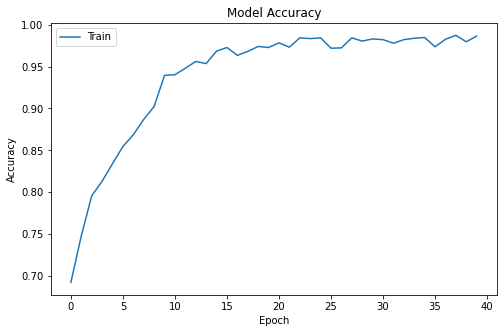

In [30]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
#plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [29]:
 history_finetunning

{'loss': [0.3208317458629608,
  0.22984811663627625,
  0.19243741035461426,
  0.1773107945919037,
  0.1588711440563202,
  0.1365235149860382,
  0.12814386188983917,
  0.11751434206962585,
  0.0938345417380333,
  0.07195667922496796,
  0.06709106266498566,
  0.0638820007443428,
  0.05538024380803108,
  0.05157838016748428,
  0.03846742957830429,
  0.03585665300488472,
  0.04725887253880501,
  0.03959275782108307,
  0.033632226288318634,
  0.03101939894258976,
  0.02785341814160347,
  0.03216468170285225,
  0.019895583391189575,
  0.020650770515203476,
  0.01888279616832733,
  0.029435789212584496,
  0.03127554431557655,
  0.01681467518210411,
  0.027365170419216156,
  0.022196754813194275,
  0.01995128206908703,
  0.031193189322948456,
  0.02187664434313774,
  0.02104949578642845,
  0.01775703765451908,
  0.027674414217472076,
  0.01723358780145645,
  0.015270581468939781,
  0.021736139431595802,
  0.016018705442547798],
 'accuracy': [0.6924061179161072,
  0.7478668689727783,
  0.795648

In [33]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df1,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


C:\Users\sai\AppData\Local\Temp\ipykernel_34532\2271427693.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)


2929/2929 [==============================] - 626s 213ms/step


In [35]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df1['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df1['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.946
Train Accuracy score : 0.938


In [36]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

C:\Users\sai\AppData\Local\Temp\ipykernel_34532\2753895509.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)


733/733 [==============================] - 156s 212ms/step


In [37]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

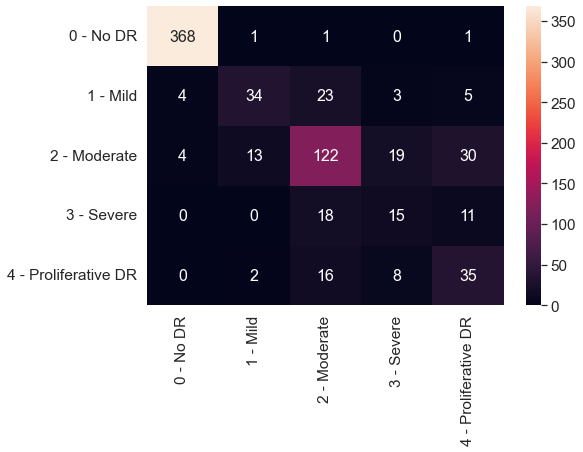

In [38]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df2['diagnosis'].astype(int)),test_labels,labels)

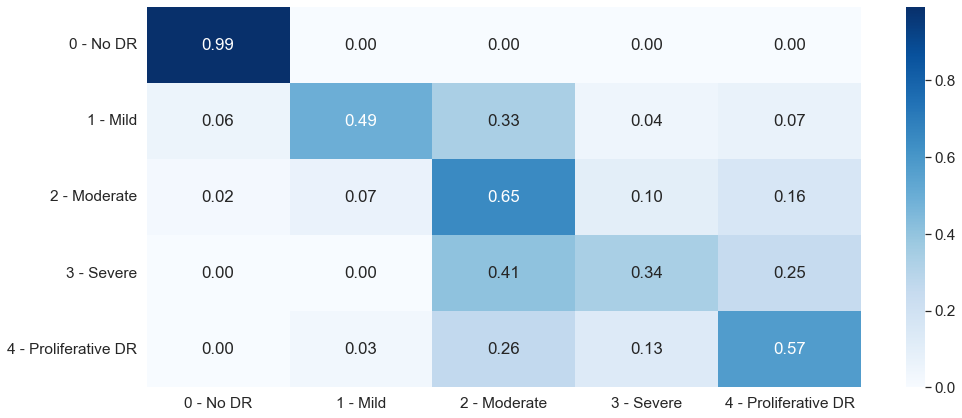

In [40]:
cnf_matrix = confusion_matrix(df2['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [41]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df2['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df2['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.856
Test Accuracy score : 0.783


In [42]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+


In [7]:
import pickle

In [8]:
Pkl_Filename='model_main.pkl'

In [49]:
with open(Pkl_Filename,'wb') as file:
    pickle.dump(model,file)

INFO:tensorflow:Assets written to: ram://02961319-7776-4b85-903c-559ab95e26a7/assets


INFO:tensorflow:Assets written to: ram://02961319-7776-4b85-903c-559ab95e26a7/assets


In [11]:
with open(Pkl_Filename,'rb')  as file:
    Pickled_Model=pickle.load(file)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://8b3bbeae-afa0-433a-96b7-f7710dfe45bc/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
Pickled_Model

In [10]:
file

<_io.BufferedReader name='model_main.pkl'>